In [1]:
from scipy.spatial.distance import pdist
import collections
import seaborn as sns
import subprocess
import numpy as np
import itertools as it
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from  imp import reload
import sys
from collections import Counter

# the repo top-k-mallows is at 
# https://github.com/ekhiru/top-k-mallows
sys.path.insert(1, '../top-k-mallows') 

import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
import rpy2.robjects as robjects

import mallows_kendall as mk
import mallows_hamming as mh
import mallows_model as mm
import permutil as pu
# import depth_utils as du


## Auxiliar functions

There are dependencies on PerMallows, an R package to sample form different distributions
in particular, for the distribtion based upon Hamming, Cayley and Ulam


In [2]:



def sample_at_dists(dist_name, dist_val, perm):
  if dist_name == 'k': return mk.sample_at_dist(n, dist_val, sk=sk, sigma0=perm)
  R = rpy2.robjects.r
  permallows = importr('PerMallows') 
  sample = np.array(permallows.rdist_perm(1, len(perm), dist_val, dist_name), dtype=int) - 1 
#   print(sample[0].dtype, perm.dtype)
  return np.array(perm)[sample[0]]


def sample_mm_dists(dist_name,n,m,theta, central):
  if dist_name == 'k': return mk.sample(m=m,n=n,theta=theta, s0=central)
  R = rpy2.robjects.r
  permallows = importr('PerMallows') 
  sample = np.array(permallows.rmm(m,list(range(1,1+n)),theta,dist_name), dtype=int) - 1 
  return np.array([np.array(central)[np.array(s)] for s in sample])

# sample_mm_dists('c',6,3,10,[5,3,4,0,1,2])
# sample_at_dists('c', 2, list(range(10))[::-1])

def prob_at_distance(max_dist, rho=10):
  p = np.array([0]+[1/(rho*i+1) for i in range(max_dist)])
  return p/p.sum()
# prob_at_distance(max_dist, rho=10)

reload(pu)
# aux code
# all neigs of perm

def list_all_neigs(perm,dist_name ='k', num_rand_neigs=None):
  n=len(perm)
  neigs = []
  if dist_name =='k' and num_rand_neigs is None:
    inver = np.argsort(perm)
    myindices = list(range(n-1))
    
    np.random.shuffle(myindices)
    for i in myindices:
        j = i+1
        a,b = inver[i],inver[j]
        perm2 = perm.copy()
        perm2[b], perm2[a] = perm2[a], perm2[b]
        neigs.append(perm2)
  elif (dist_name == 'c' or dist_name == 'h') and num_rand_neigs is None:
    myindices =list(it.combinations(range(n),2))
    np.random.shuffle(myindices)
    for (i,j) in  myindices:
      perm2 = perm.copy()
      perm2[i], perm2[j] = perm2[j], perm2[i]
      neigs.append(perm2)
  elif dist_name == 'u' and num_rand_neigs is None:
#     there are repeated permus in neigs
    inve = np.argsort(perm)
    for i in range(n):
      for j in range(n):
        if i!= j :
          inve2 = np.concatenate([inve[:i],inve[i+1:]]).copy()
          inve2 = np.insert(inve2,j,inve[i])
          perm2 = np.argsort(inve2)
    #       print(pu.ulam_dist(perm,perm2))
          neigs.append(perm2) 
  elif num_rand_neigs is not None:
    max_dist = pu.max_dist(n,dist_name)
    for i in range(num_rand_neigs):
      dist_val = np.random.choice(1+max_dist,p=prob_at_distance(max_dist,10))
      perm2 = sample_at_dists(dist_name, dist_val, perm)
      neigs.append(perm2)
  return neigs
# list_all_neigs(perm,dist_name ='u', num_rand_neigs=None)



def find_neigs(perm,P,sample=None,dist_name='k',method='best',num_rand_neigs=None):
    inver = np.argsort(perm)
    best_perm = None
    best_depth = len(sample)*pu.max_dist(n,dist_name) - pu.dist_to_sample(perm,P, dist_name,sample)#pu.dist_to_sample(perm,P)
    for sigma in list_all_neigs(perm,dist_name, num_rand_neigs=num_rand_neigs):
#       print(sigma, mk.distance(perm,sigma))
      depth = len(sample)*pu.max_dist(n,dist_name) - pu.dist_to_sample(sigma,P, dist_name,sample)#pu.dist_to_sample(perm,P)
#       print(perm, sigma, best_depth, depth)
      if best_depth < depth:
          if method == 'first' or method == 'random': 
              return sigma
          best_depth = depth
          best_perm = sigma.copy()
    return best_perm      
      

# sigma = find_neigs(perm,P,sample,dist_name_depth,f_obj,method,num_rand_neigs)
# print(sigma, mk.distance(perm,sigma),"last")





def plot_path(P, dfpaths, sample, dist_name, central=None, ax=None, save_path=None):
    res=[]
    if central is None: central = list(range(len(sample[0])))
    if ax is None: f, ax = plt.subplots(1,1, figsize=(6,4))
    res = []
    deepest = None # = [depth,dist]
    for perm in sample:
      depth = len(sample)*pu.max_dist(n,dist_name) - pu.dist_to_sample(perm,P,dist_name=dist_name, sample=sample)
      dist = pu.distance(perm,central,dist_name)
      res.append([depth,dist])
      if deepest is None or deepest[0] > depth:
        deepest = [depth,dist]
    df = pd.DataFrame(res,columns=['Depth', 'Distance to the center'])
    df = df.groupby(['Depth', 'Distance to the center']).size().reset_index(name='freq').reset_index(drop=True)
    sns.scatterplot(data=df, x="Distance to the center", y="Depth",ax=ax)#,color=".2", hue='freq'
    plt.title("n="+str(n)+", m="+str(m))
    plt.xlabel(r'$d(\sigma, \sigma^*)$')
    plt.ylabel(r'$\widehat D(\sigma)$')
    num_paths = dfpaths.num_path.nunique()
    print(num_paths)
    for num_path in range(num_paths):
        aux = dfpaths[dfpaths.num_path==num_path]
        ax.plot(aux.dist, aux.depth,'r-',alpha=.5)
        ax.plot(aux.iloc[-1].dist, aux.iloc[-1].depth, 'rx')
    ax.grid(True)
    if save_path is not None: plt.savefig(save_path)
    return deepest, ax
#     sns.heatmap(P,ax=ax[1])
def Borda(rankings): 
  return np.argsort(np.argsort(rankings.sum(axis=0)))
# f, ax = plt.subplots(1,3, figsize=(7,4))
# plot_path(P, dfpath,sample, dist_name_depth,ax=ax[1])


## Main function


In [3]:
reload(pu)
reload(mk)

def run_one(n,m,theta,dist_name_gen, dist_name_depth,method='first', maxiter=100, ax=None, repe=0, num_paths=1):
  if method=='random' : num_rand_neigs=n**2
  else:  num_rand_neigs= None
    
  central = np.arange(n)
  sk = mk.num_perms_at_dist(n)
  max_dist = pu.max_dist(n,dist_name_depth)
  sample = sample_mm_dists(dist_name_gen,n,m,theta, central)
  P = None
  if dist_name_depth == 'h' or dist_name_depth == 'c' or dist_name_depth == 'u': P = pu.sample_to_marg(sample,'absolute')
  if dist_name_depth == 'k': P = pu.sample_to_marg(sample,'relative')
  dfpaths=pd.DataFrame()
  for num_path in range(num_paths):
    dist_vals, pairs, path = [], [], []
    contiter, jumps = 0 , 0
    perm = np.random.permutation(range(n))#perm_ini.copy()
    depth = pu.max_dist(n, dist_name_depth) - pu.dist_to_sample(perm,P, dist_name_depth,sample), 
    dist = pu.distance(perm, central , dist_name=dist_name_depth)
    # print("check fast depth works" , depth, pu.dist_to_sample_slow(perm, dist_name_depth, sample))
    halt = False
    while not halt and contiter<maxiter:#
      contiter+=1
      perm2 = find_neigs(perm,P,sample,dist_name_depth,method,num_rand_neigs)
      if perm2 is None : halt=True
      else:
        assert(pu.distance(perm,perm2,dist_name_depth)==1)
        depth = len(sample)*pu.max_dist(n, dist_name_depth) - pu.dist_to_sample(perm2,P, dist_name_depth,sample)
        dist = pu.distance(perm2, central , dist_name=dist_name_depth)
        path.append([dist_name_gen, dist_name_depth,depth,dist,num_path])
        perm = perm2
    if contiter == maxiter: print("öjooooo MAX ITER reached")
    dfpath = pd.DataFrame(path,columns=['dist_name_gen', 'dist_name_depth','depth', 'dist', 'num_path'])
    dfpaths = pd.concat([dfpaths,dfpath])
  
  ##set_median_dists = dfpath[dfpath.depth==dfpath.depth.max()].dist.values #the dist of the deepest rankings in the sample
  save_path='img/path_'+dist_name_gen+ dist_name_depth+'_n'+str(n)+'_m'+str(m)+'_t'+str(theta)+'_'+str(repe)+'.pdf'
  deepest, ax = plot_path(P, dfpaths,sample, dist_name_depth, ax=ax, save_path=save_path)
  #print("Distances to center of the deepest* in path: ", (set_median_dists,   dfpath.dist.min()),". in the sample:", deepest, "Borda: ", mk.distance(Borda(sample)))
  return dfpaths, ax
  



# Running the main function
Set the parameters and run the main function

3


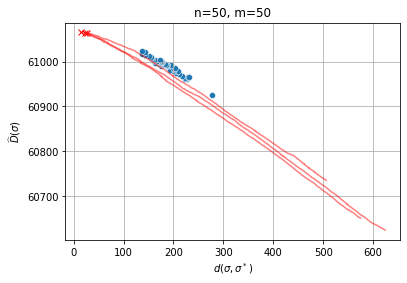

In [4]:
n = 50
m = 50
theta = .2
repe = 0
dist_name_gen, dist_name_depth ='k', 'k'
method = 'random' # first, best, random #OJO first y random hacen lo mismo (check)
sk = mk.num_perms_at_dist(n)
# f, ax = plt.subplots(1,3, figsize=(17,4))
dfpaths, miax = run_one(n,m,theta,dist_name_gen, dist_name_depth,method='first', maxiter=20*pu.max_dist(n, dist_name_depth), repe=repe,num_paths=3)

